In [1]:
#Importo la librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score
import sklearn

import warnings
warnings.filterwarnings('ignore')

#conda install -c conda-forge hdbscan ##intalar HDBSCAN si no estuviera en el entorno 
import hdbscan

# Predictor de Puntaje
## Limpieza y preparacion de set de datos

In [2]:
#importo el dataset y hago revision de los datos

df = pd.read_csv("titles_filtrado.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5850 non-null   int64  
 1   id                    5850 non-null   object 
 2   title                 5849 non-null   object 
 3   type                  5850 non-null   object 
 4   description           5832 non-null   object 
 5   release_year          5850 non-null   int64  
 6   age_certification     3231 non-null   object 
 7   runtime               5850 non-null   int64  
 8   genres                5850 non-null   object 
 9   production_countries  5850 non-null   object 
 10  seasons               2106 non-null   float64
 11  imdb_id               5447 non-null   object 
 12  imdb_score            5850 non-null   float64
 13  imdb_votes            5352 non-null   float64
 14  tmdb_popularity       5759 non-null   float64
 15  tmdb_score           

In [3]:
# Drop de columnas innecesarias
df.drop("id", inplace=True, axis=1)

df.drop("imdb_id", inplace=True, axis=1)

# Limpio `genres` y `production_countries`, devuelta tomando el primer elemento de de la lista que cada valor retenga
def parse_list(row):
    parsed = str(row)[1:-1].split(",")
    for i in range(len(parsed)):
        parsed[i] = parsed[i].strip()[1:-1]
        
    return parsed[0] if parsed[0] != '' else 'N/A'

df['genres_parsed'] = df['genres'].map(parse_list)
df['prod_countries_parsed'] = df['production_countries'].map(parse_list)

In [4]:
# Añado la columna 'is_movie'
df['is_movie'] = df.type.map(lambda x: 0 if x == 'SHOW' else 1)

In [5]:
# Obtengo todos los valores nulos
df.isnull().sum()

Unnamed: 0                  0
title                       1
type                        0
description                18
release_year                0
age_certification        2619
runtime                     0
genres                      0
production_countries        0
seasons                  3744
imdb_score                  0
imdb_votes                498
tmdb_popularity            91
tmdb_score                  0
genres_parsed               0
prod_countries_parsed       0
is_movie                    0
dtype: int64

In [6]:
# Drop de columnas innecesarias
df.drop("title", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)

# Relleno valores nulos
df['age_certification'].fillna("N/A", inplace=True)
df['seasons'].fillna(0.0, inplace=True)
df['tmdb_popularity'].fillna(df['tmdb_popularity'].mean(), inplace=True)
df['imdb_votes'].fillna(df['imdb_votes'].mean(), inplace=True)


# Confirmo que no queden valores nulos
df.isnull().sum()

Unnamed: 0               0
type                     0
release_year             0
age_certification        0
runtime                  0
genres                   0
production_countries     0
seasons                  0
imdb_score               0
imdb_votes               0
tmdb_popularity          0
tmdb_score               0
genres_parsed            0
prod_countries_parsed    0
is_movie                 0
dtype: int64

In [7]:
df.describe()

,Unnamed: 0,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,is_movie
count,5850.000000,5850.000000,5850.000000,5850.000000,5850.000000,5.850000e+03,5850.000000,5850.000000,5850.000000
mean,2924.500000,2016.417094,76.888889,0.778632,6.509966,2.343938e+04,22.637925,6.827573,0.640000
std,1688.893869,6.937726,39.002509,1.918422,1.114846,9.165053e+04,81.042373,1.139020,0.480041
min,0.000000,1945.000000,0.000000,0.000000,1.500000,5.000000e+00,0.009442,0.500000,0.000000
25%,1462.250000,2016.000000,44.000000,0.000000,5.900000,6.042500e+02,2.765250,6.200000,0.000000
50%,2924.500000,2018.000000,83.000000,0.000000,6.500000,2.803500e+03,6.962000,6.800000,1.000000
75%,4386.750000,2020.000000,104.000000,1.000000,7.300000,1.777225e+04,17.406500,7.500000,1.000000
max,5849.000000,2022.000000,240.000000,42.000000,9.600000,2.294231e+06,2274.044000,10.000000,1.000000


In [8]:
#Quito las producciones que posean pocos votos ya que su puntacion es dudosa

indexNames = df[df['imdb_votes'] <= 5e+02].index

df.drop(indexNames , inplace=True)

df.round({'imdb_score': 0})

,Unnamed: 0,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genres_parsed,prod_countries_parsed,is_movie
0,0,SHOW,1945,TV-MA,51,['documentation'],['US'],1.0,6.0,23439.382474,0.600000,6.8,documentation,US,0
1,1,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0.0,8.0,808582.000000,40.965000,8.2,drama,US,1
2,2,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],0.0,8.0,107673.000000,10.010000,7.3,drama,US,1
3,3,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],0.0,8.0,534486.000000,15.461000,7.8,fantasy,GB,1
4,4,MOVIE,1967,N/A,150,"['war', 'action']","['GB', 'US']",0.0,8.0,72662.000000,20.398000,7.6,war,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,5832,MOVIE,2021,N/A,106,"['romance', 'comedy']","['GB', 'IN']",0.0,4.0,792.000000,1.589000,5.3,romance,GB,1
5833,5833,SHOW,2021,TV-14,24,['comedy'],['NG'],1.0,6.0,23439.382474,0.840000,6.8,comedy,NG,0
5840,5840,MOVIE,2022,N/A,26,[],[],0.0,6.0,23439.382474,1.179000,7.0,N/A,N/A,1
5844,5844,MOVIE,2021,N/A,35,[],['US'],0.0,6.0,23439.382474,22.637925,6.8,N/A,US,1


## Aplicacion de modelos de regression

In [9]:
# Trasnfromamos las variables categoricas en numericas
all_data = pd.get_dummies(df[[  'age_certification',
                                'genres_parsed', 
                                'prod_countries_parsed', 
                                'imdb_votes', 
                                'seasons', 
                                'is_movie',
                                'release_year',
                                'runtime']])



In [10]:
# Creamos las variables base

X = all_data.copy()
y = df.pop('imdb_score')

In [11]:
#Creo las variables de prueba y entrenamiento

from sklearn.model_selection import train_test_split, cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Metodo de verificacion

Como han aparecido varias discrepancias en los metodos de scoring de los modelos por parte de las librerias propias de Sklearn, adoptamos el uso del siguiente metodo para poder visualizar el promedio de los errores cuadrados, absolutos y absoluto porcentual.

In [12]:
#Este es un metodo para ver el error en el modelo

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def score_dataset(X_train, X_valid, y_train, y_valid, model=RandomForestRegressor(n_estimators=1000, random_state=0)):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return {"mean_squared_error": mean_squared_error(y_valid, preds), "mean_absolute_error": mean_absolute_error(y_valid, preds), "mean_absolute_percentage_error": mean_absolute_percentage_error(y_test, preds)}
    

#### Regresion lineal

In [13]:
#Regresion Lineal

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [14]:
#Hacemos nuestras predicciones
y_lin = regressor.predict(X_test)
regressor.score(X_test, y_test)

0.2266123272771191

In [15]:
# Vemos los errores

scores = -1 * cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=LinearRegression())

{'mean_squared_error': 0.8860196119045364,
 'mean_absolute_error': 0.7118934206100683,
 'mean_absolute_percentage_error': 0.12125676486561332}

#### Regresion Bayesiana

In [16]:
from sklearn.linear_model import BayesianRidge

#Hacemos predicciones

bayreg = BayesianRidge(n_iter=10000)
bayreg.fit(X_train, y_train)
y_bay = bayreg.predict(X_test)
bayreg.score(X_test,y_test)

0.23650871327698475

In [17]:
# Vemos los errores

scores = -1 * cross_val_score(bayreg, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=BayesianRidge())

{'mean_squared_error': 0.8746819705221912,
 'mean_absolute_error': 0.7069995422075095,
 'mean_absolute_percentage_error': 0.12060266478188778}

#### Busqueda por Emparejamiento Ortogonal

In [18]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

orthreg = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())
orthreg.fit(X_train, y_train)

#Hacemos las predicciones

y_orth = orthreg.predict(X_test)
orthreg.score(X_test,y_test)

0.2184950091347383

In [19]:
# Vemos los errores

scores = -1 * cross_val_score(orthreg, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=OrthogonalMatchingPursuit())

{'mean_squared_error': 0.8953190917435365,
 'mean_absolute_error': 0.7196882474208126,
 'mean_absolute_percentage_error': 0.12226947267898051}

#### Regresion LASSO

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [1, 10 , 100], 'max_iter': [1, 10,100], 'tol': [1e-2, 1, 10], 'selection': ['cyclic','random']}

#Hago estimaciones de que parametros usar

grid = GridSearchCV(Lasso(),param_grid,refit=True,verbose=2)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END ....alpha=1, max_iter=1, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END ....alpha=1, max_iter=1, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END ....alpha=1, max_iter=1, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END ....alpha=1, max_iter=1, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END ....alpha=1, max_iter=1, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END .......alpha=1, max_iter=1, selection=cyclic, tol=1; total time=   0.0s
[CV] END .......alpha=1, max_iter=1, selection=cyclic, tol=1; total time=   0.0s
[CV] END .......alpha=1, max_iter=1, selection=cyclic, tol=1; total time=   0.0s
[CV] END .......alpha=1, max_iter=1, selection=cyclic, tol=1; total time=   0.0s
[CV] END .......alpha=1, max_iter=1, selection=cyclic, tol=1; total time=   0.0s
[CV] END ......alpha=1, max_iter=1, selection=cyclic, tol=10; total time=   0.0s
[CV] END ......alpha=1, max_iter=1, selection=c

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [1, 10, 100], 'max_iter': [1, 10, 100],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.01, 1, 10]},
             verbose=2)

In [21]:
#Reviso los mejores parametros

print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Lasso(alpha=1, max_iter=100, selection='random', tol=0.01)
{'alpha': 1, 'max_iter': 100, 'selection': 'random', 'tol': 0.01}
0.07071616495702293


In [24]:
#Creo el metodo Lasso

lassoreg = Lasso(alpha=1, max_iter=100, selection='random', tol=0.01)
lassoreg.fit(X_train, y_train)

# Hago las predicciones

y_lasso = lassoreg.predict(X_test)
lassoreg.score(X_test,y_test)

0.075287595073952

In [25]:
# Vemos los errores

scores = -1 * cross_val_score(lassoreg, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=Lasso())

{'mean_squared_error': 1.0593824381906387,
 'mean_absolute_error': 0.7806799764384812,
 'mean_absolute_percentage_error': 0.1328576982114495}

#### Regresion Vectorial

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1 , 10, 100], 'epsilon': [0.1,1,10],'kernel': ['sigmoid','rbf']}

#Hago estimaciones de que parametros usar

grid = GridSearchCV(SVR(cache_size=500),param_grid,refit=True,verbose=2)

grid.fit(X_train,y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...................C=1, epsilon=0.1, kernel=sigmoid; total time=   0.6s
[CV] END ...................C=1, epsilon=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ...................C=1, epsilon=0.1, kernel=sigmoid; total time=   0.6s
[CV] END ...................C=1, epsilon=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=1, epsilon=0.1, kernel=sigmoid; total time=   0.9s
[CV] END .......................C=1, epsilon=0.1, kernel=rbf; total time=   0.9s
[CV] END .......................C=1, epsilon=0.1, kernel=rbf; total time=   0.9s
[CV] END .......................C=1, epsilon=0.1, kernel=rbf; total time=   1.0s
[CV] END .......................C=1, epsilon=0.1, kernel=rbf; total time=   1.0s
[CV] END .......................C=1, epsilon=0.1, kernel=rbf; total time=   1.0s
[CV] END .....................C=1, epsilon=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=1, epsilon=1, ke

GridSearchCV(estimator=SVR(cache_size=500),
             param_grid={'C': [1, 10, 100], 'epsilon': [0.1, 1, 10],
                         'kernel': ['sigmoid', 'rbf']},
             verbose=2)

In [27]:
# Revisamos los mejores parametros

print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

SVR(C=1, cache_size=500, epsilon=1)
{'C': 1, 'epsilon': 1, 'kernel': 'rbf'}
0.046763032971632826


In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Armamos el modelo

SVR_regr = make_pipeline(StandardScaler(), SVR(C=10, epsilon=1, kernel='rbf', cache_size=500))
SVR_regr.fit(X_train, y_train)

#Realizamos las predicciones

y_svr=SVR_regr.predict(X_test)
SVR_regr.score(X_test,y_test)


0.20217220429344585

In [29]:
#Vemos los errores

scores = -1 * cross_val_score(SVR_regr, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=SVR())

{'mean_squared_error': 1.098899082947524,
 'mean_absolute_error': 0.7881899422282084,
 'mean_absolute_percentage_error': 0.13532384801837538}

In [30]:
# Creamos un dataframe con las predicciones realizadas

df_predicciones = pd.DataFrame({'Actual': y_test, 
                                'Predicted_Lin': y_lin, 
                                'Predicted_Bayesian': y_bay,
                                'Predicted_OrthMatch': y_orth,
                                'Predicted_Lasso': y_lasso,
                                'Predicted_SVR': y_svr})
df_predicciones

,Actual,Predicted_Lin,Predicted_Bayesian,Predicted_OrthMatch,Predicted_Lasso,Predicted_SVR
5447,6.7,6.537640,6.531958,6.355066,6.273721,6.589466
2206,5.8,6.589604,6.553047,6.696324,6.779799,6.974867
1228,6.6,6.431126,6.423431,6.537245,6.513756,6.270145
1949,7.0,7.189100,7.173920,7.112576,6.645085,6.698285
4482,3.8,5.435535,5.699709,5.938125,6.420827,5.262438
...,...,...,...,...,...,...
4606,6.5,6.279722,6.267876,6.009220,6.624074,6.517362
3503,3.0,6.197741,6.191800,6.177214,6.495600,6.200267
4990,8.1,6.877370,6.850411,6.822638,6.772144,6.593763
2529,6.4,6.541649,6.604753,6.788311,6.467467,6.800251


In [31]:
#Agregamos la columna de promedio de las predicciones realizadas

df_predicciones['Promedio']= (  df_predicciones['Predicted_Lin'] + 
                                df_predicciones['Predicted_Bayesian'] +
                                df_predicciones['Predicted_OrthMatch'] +
                                df_predicciones['Predicted_Lasso'] +
                                df_predicciones['Predicted_SVR']) /5

df_predicciones

,Actual,Predicted_Lin,Predicted_Bayesian,Predicted_OrthMatch,Predicted_Lasso,Predicted_SVR,Promedio
5447,6.7,6.537640,6.531958,6.355066,6.273721,6.589466,6.457570
2206,5.8,6.589604,6.553047,6.696324,6.779799,6.974867,6.718728
1228,6.6,6.431126,6.423431,6.537245,6.513756,6.270145,6.435141
1949,7.0,7.189100,7.173920,7.112576,6.645085,6.698285,6.963793
4482,3.8,5.435535,5.699709,5.938125,6.420827,5.262438,5.751327
...,...,...,...,...,...,...,...
4606,6.5,6.279722,6.267876,6.009220,6.624074,6.517362,6.339651
3503,3.0,6.197741,6.191800,6.177214,6.495600,6.200267,6.252524
4990,8.1,6.877370,6.850411,6.822638,6.772144,6.593763,6.783265
2529,6.4,6.541649,6.604753,6.788311,6.467467,6.800251,6.640486


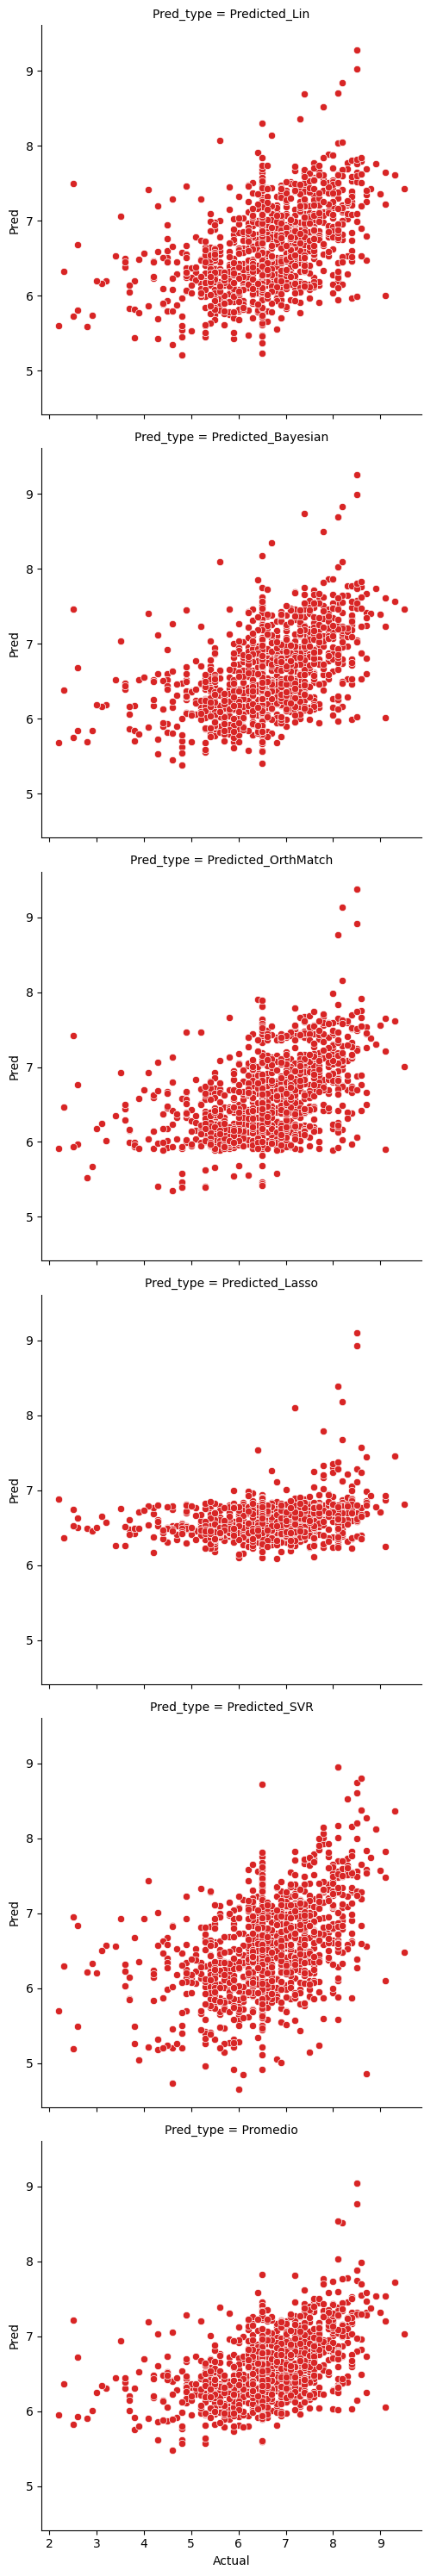

In [32]:
# Graficamos

df_to_scatter = df_predicciones.melt('Actual',var_name='Pred_type', value_name='Pred')
colors = ["#d82525", "#464646"]

sns.set_palette(sns.color_palette(colors))
g = sns.FacetGrid(df_to_scatter, row="Pred_type", height=5, palette="red")
g.map(sns.scatterplot, "Actual", "Pred")
g.add_legend()


In [33]:
df_predicciones['diferencia'] = (df_predicciones["Actual"] - df_predicciones["Promedio"])*100/2
print(
df_predicciones['diferencia'].median(),
df_predicciones['diferencia'].mean()
)

5.868532179093822 1.537036570464514


# Recomendador de Producciones

In [34]:
df_titles = pd.read_csv("titles.csv") 

#Preparacion de datos para convertirlos a dummy/indicadores

df_titles['production_countries'] = df_titles['production_countries'].str.strip() #saco los espacios adelante y detras
df_titles['production_countries'] = df_titles['production_countries'].str.strip("[]") #saco los parentesis de la columna año
df_titles['production_countries'] = df_titles['production_countries'].str.split(expand=True)[0]#me quedo solo con el primer pais registrado
df_titles['production_countries'] = df_titles['production_countries'].str.strip(",")#saco una coma residual
#lo mismo para genero
df_titles['genres'] = df_titles['genres'].str.strip() #saco los espacios adelante y detras
df_titles['genres'] = df_titles['genres'].str.strip("[]") #saco los parentesis de la columna año
df_titles['genres'] = df_titles['genres'].str.split(expand=True)[0]#me quedo solo con el primer genero registrado
df_titles['genres'] = df_titles['genres'].str.strip(",") #saco una coma residual

df_titles.type = df_titles.type.replace({"SHOW": 1, "MOVIE": 0}) #convierto en 0 para serie y 1 para peliculas

#Relleno con ceros las peliculas que tienen valor de temporada NaN como defecto
values = {"seasons": 0}
df_titles.fillna(value=values, inplace= True) 

#descarto el resto de NaN

df_titles.dropna(inplace=True)  
# df.dropna(subset=['name', 'toy'])
df_titles.shape

(2904, 15)

In [35]:
#selecciono las features que iran al DF de entrenamiento
df_cluster = df_titles[['type',
                        'release_year',
                        'age_certification',
                        'runtime','genres',
                        'production_countries',
                        'seasons',
                        'imdb_votes',
                        'tmdb_popularity']]
df_cluster = pd.get_dummies(df_cluster) #realizo la conversion de object a indicadores(dummies)
df_cluster.head()

,type,release_year,runtime,seasons,imdb_votes,tmdb_popularity,age_certification_G,age_certification_NC-17,age_certification_PG,age_certification_PG-13,...,production_countries_'SG',production_countries_'SN',production_countries_'TH',production_countries_'TR',production_countries_'TW',production_countries_'UA',production_countries_'US',production_countries_'XX',production_countries_'ZA',production_countries_'ZW'
1,0,1976,114,0.0,808582.0,40.965,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1972,109,0.0,107673.0,10.010,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1975,91,0.0,534486.0,15.461,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1969,30,4.0,73424.0,17.617,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1979,94,0.0,395024.0,17.770,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# ALGORITMO HDBSCAN

In [36]:
#Instanciamos el algoritmo
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                 min_samples=10,prediction_data=True)
                 
#Entrenamos
clusterer.fit(df_cluster)

HDBSCAN(min_cluster_size=20, min_samples=10, prediction_data=True)

In [37]:
print("Etiquetas de los clusters: ", np.unique(clusterer.labels_))
print("Cantidad de clusters: ", len(np.unique(clusterer.labels_)))

Etiquetas de los clusters:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]
Cantidad de clusters:  34


### Como se puede ver se generan 34 Clusters diferentes, el cual el -1 es para identificar los outliers

## Prediccion de nuevos puntos

In [54]:
df_test24 = pd.read_excel('clusterdummy24.xlsx')#XLSX fitlrado con solo titulos de cluster 24

In [55]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_test24)
test_labels

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [56]:
df_test317 = pd.read_excel('clusterdummy317.xlsx')#XLSX fitlrado con solo titulos de cluster 3 y de cluster 17

In [57]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_test317)
test_labels

array([ 3,  3,  3,  3, 17,  3,  3, 17, 17,  3,  3, 17,  3, 17, 17, 17,  3,
        3,  3,  3, 17,  3,  3,  3,  3,  3, 17,  3, 17,  3, 17, 17, 17, 17,
       17,  3, 17, 17,  3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17,  3, 17, 17, 17,  3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17])

## Grafico Sin outliers

In [58]:
df_clusterout = pd.read_excel('clusterdummyout.xlsx')#XLSX fitlrado sin outlier(cluster -1)

In [59]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_clusterout)
test_labels

array([ 7,  3,  7, ..., 29, 30, 29])

In [61]:
df_clusterout.plot(kind='scatter', x='release_year', y='runtime', c=test_labels, cmap='Accent_r', figsize=(16,10))
df_clusterout.plot(kind='scatter', x='runtime', y='imdb_votes', c=test_labels, cmap='Accent_r', figsize=(16,10))

AttributeError: 'NoneType' object has no attribute 'canvas'

## Grafico de outliers

In [62]:
#grafico de outliers
plt.figure(figsize=(14, 10))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
plt.grid()
plt.show()

AttributeError: 'NoneType' object has no attribute 'canvas'

# Perfil Usuario

In [63]:
#creo un nuevo dataframe con una columna con la info de a que cluster pertenece
df_titles_clustered = df_titles[['title',
                        'type',
                        'release_year',
                        'genres',
                        'production_countries',
                        'imdb_score']]
df_titles_clustered['cluster'] = clusterer.labels_
#df_titles_clustered =  df_titles_clustered[df_titles_clustered.cluster != -1] #elimino los outliers (Cluster -1)       

In [64]:
tipo = int(input("Recomendar Serie o Pelicula? (0 para pelicula , 1 para serie): "))

In [65]:
#DEFINO (O REINICIO) los generos y el df del perfil
generos_disponibles = np.unique(df_titles['genres']) #creo un array con los generos del DF
gral = pd.DataFrame(columns= df_titles_clustered.columns) #definimos el dataframe (o reiniciamos)

In [66]:
for l in range(6): #defino una cantidad de 6 filmes para poder sacar un comun denominador

    print('Seleccionemos un genero de los restantes')
    for item in generos_disponibles:
        print(item)
    genero = input("Elige un genero de los disponibles : ")
    genre = "'"+genero+"'" #arreglo para coincidir con el formato del DF
    
    #genero un nuevo df filtrando el tipo y genero seleccionado ordenando por mayor IMDB
    choices = df_titles_clustered[(df_titles_clustered.type == tipo) & (df_titles_clustered.genres == genre)].sort_values(by = "imdb_score",ascending=False)
    
    #del df filtrado por tipo y genero muestro los primeros 10 con mejor IMDB
    j=0
    for item in choices['title']:
        if j<10:
            print(j , "_ ",item)
            j +=1
    k = int(input("De estos titulos de " + genero + " selecciona el que mas te gustó: "))#pido al usuario seleccionar una opcion

    gral = gral.append(choices.iloc[k]) #agrego la fila con los datos del titulo seleccionado
    
    generos_disponibles = np.delete(generos_disponibles, np.argwhere(generos_disponibles == genre)) #borro de los generos disponibles la opcion previamente elegida

    

Seleccionemos un genero de los restantes
'action'
'animation'
'comedy'
'crime'
'documentation'
'drama'
'family'
'fantasy'
'history'
'horror'
'music'
'reality'
'romance'
'scifi'
'sport'
'thriller'
'war'
'western'


KeyboardInterrupt: Interrupted by user

In [14]:
gral #vemos como quedó conformada la seleccion del usuario

,title,type,release_year,genres,production_countries,imdb_score,cluster
237,Inception,0,2010,'action','US',8.8,-1
815,The Rise of Kirmada,0,2012,'animation','IN',8.2,29
3381,Dave Chappelle: Sticks & Stones,0,2019,'comedy','US',8.4,14
98,Snatch,0,2000,'crime','US',8.3,-1
1203,Gantz:O,0,2016,'scifi','JP',7.1,18
891,Metallica: Through the Never,0,2013,'music','US',7.1,17


In [15]:
cluster_usuario = gral['cluster'].value_counts().idxmax() #tomo el valor del cluster que mas se repite
cluster_usuario #visualizo el cluster del perfil del usuario

-1

In [16]:
#recomendamos peliculas en base al cluster del perfil y muestro las primeras 5 con el mejor IMDB

print("Te recomendamos estos titulos: ")
df_titles_clustered[(df_titles_clustered.type == tipo) & (df_titles_clustered.cluster == cluster_usuario)].sort_values(by = "imdb_score",ascending=False).head(5)

Te recomendamos estos titulos: 


,title,type,release_year,genres,production_countries,imdb_score,cluster
2547,C/o Kancharapalem,0,2018,'drama','IN',8.9,-1
97,Forrest Gump,0,1994,'drama','US',8.8,-1
237,Inception,0,2010,'action','US',8.8,-1
4818,Bo Burnham: Inside,0,2021,'comedy','US',8.7,-1
36,GoodFellas,0,1990,'drama','US',8.7,-1
